## 🌡️🦠Pneumonia Detection Model

### Import necessary libraries

In [1]:
#!pip install -U git+https://github.com/albumentations-team/albumentations
#!pip install np_utils

In [2]:
%%time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
#____________________________________________________________

import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
# from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split

#____________________________________________________________

from tqdm.notebook import tqdm
from termcolor import colored
# import albumentations as A

#____________________________________________________________


print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Required libraries were succesfully imported...
CPU times: total: 15.6 ms
Wall time: 16.6 ms


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the datasets

In [4]:
%%time

train_df = glob.glob("/content/drive/MyDrive/chest_xray/train/**/*.jpeg")
test_df = glob.glob("/content/drive/MyDrive/chest_xray/test/**/*.jpeg")
validation_df = glob.glob("/content/drive/MyDrive/chest_xray/**/*.jpeg")

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

The datasets were succesfully loaded...
CPU times: user 87.7 ms, sys: 15.7 ms, total: 103 ms
Wall time: 20.8 s


### Look at train and test sets

In [5]:
train_df[:5], test_df[:5]

(['/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0520-0001.jpeg',
  '/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0543-0001.jpeg',
  '/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0543-0001-0002.jpeg',
  '/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0525-0001-0001.jpeg',
  '/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0531-0001.jpeg'],
 ['/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg',
  '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg',
  '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_480.jpeg',
  '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg',
  '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg'])

### Do some data exploration

#### How many images are in each dataset? 

In [6]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the test dataset".format(len(test_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 5216 images in the training dataset
There is 624 images in the test dataset
There is 0 images in the validation dataset


#### How many of the pictures are of pneumonic lungs and how many are of normal lungs 

In [7]:
datasets, pneumonia_lung, normal_lung = ["train", "test", "val"], [], []
directory = "/content/drive/MyDrive/chest_xray/"
for i in datasets:
    path = os.path.join(directory, i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    normal_lung.extend(normal), pneumonia_lung.extend(pneumonia)

print("The number of pneumonia images is {}".format(len(pneumonia_lung)))
print("The number of non-pneumonia images is {}".format(len(normal_lung)))

The number of pneumonia images is 4273
The number of non-pneumonia images is 1583


#### Shuffle the images

In [8]:
random.shuffle(normal_lung)
random.shuffle(pneumonia_lung)
images = normal_lung[:50] + pneumonia_lung[:50]
images[:10]

['/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL2-IM-1185-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL2-IM-1422-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0555-0001-0002.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL2-IM-1094-0001-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0665-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL2-IM-0386-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0456-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/test/NORMAL/NORMAL2-IM-0098-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0658-0001.jpeg',
 '/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0140-0001.jpeg']

#### View the images in X-ray format 


NORMAL


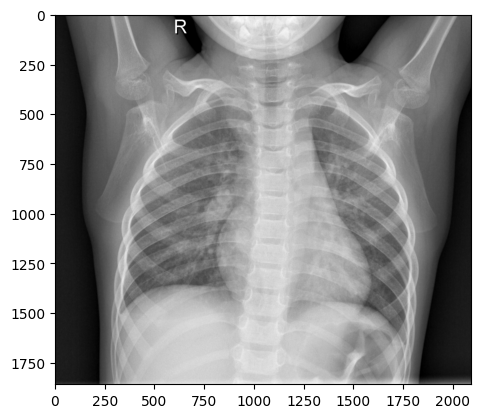

In [9]:
normal_lung_image = load_img("/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
print("NORMAL")
plt.imshow(normal_lung_image)
plt.show()

PNEUMONIA


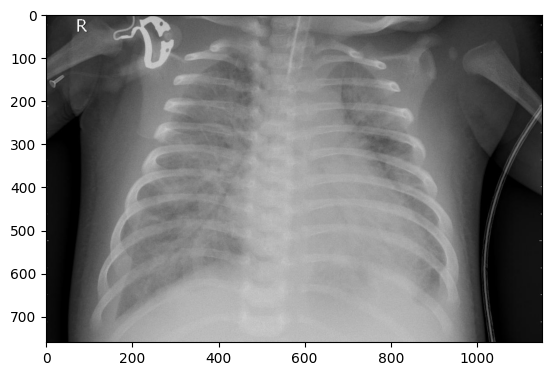

In [10]:
normal_lung_image = load_img("/content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
print("PNEUMONIA")
plt.imshow(normal_lung_image)
plt.show()

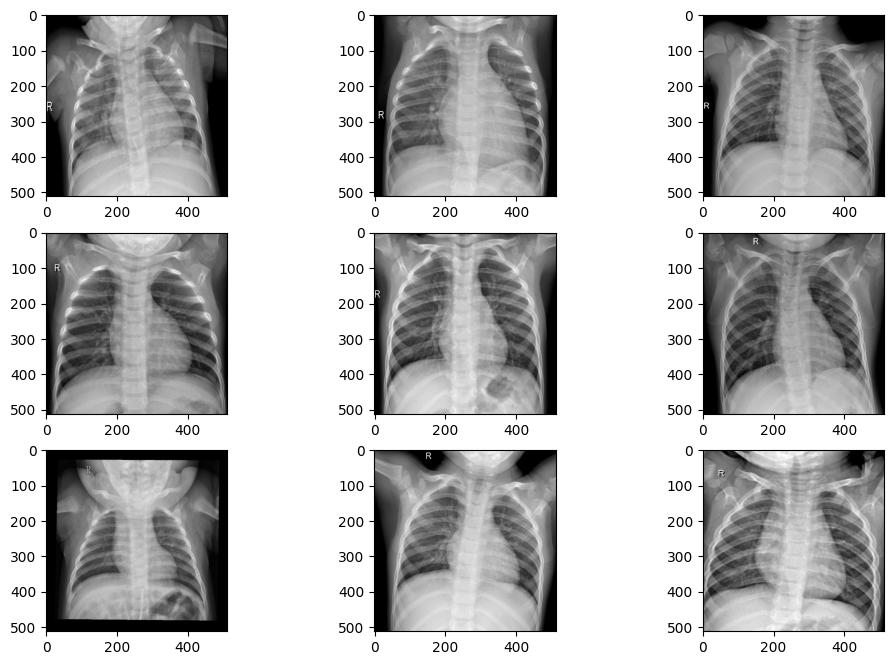

In [50]:
fig = plt.figure(figsize = (12, 8))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

#### Image erosion

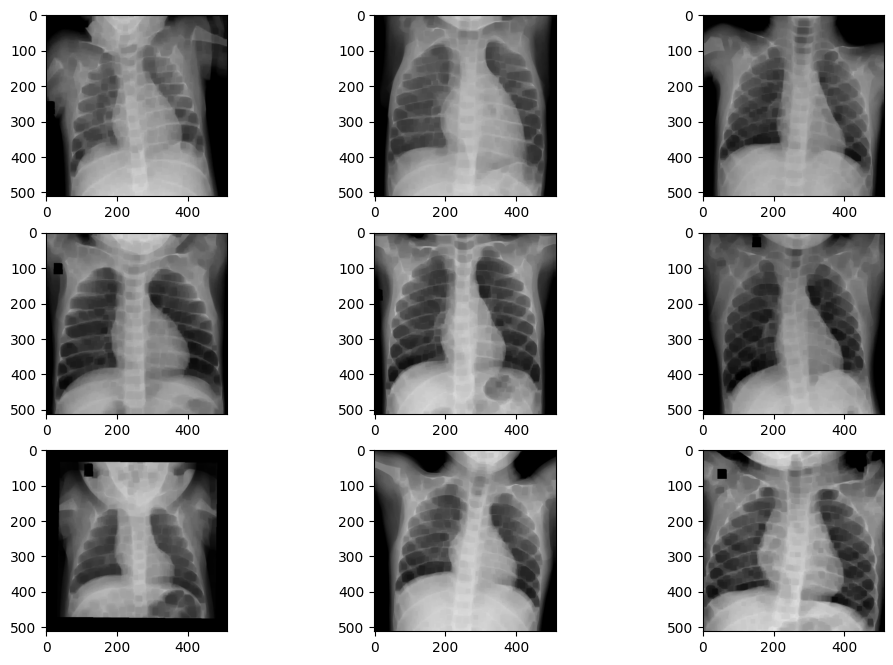

In [51]:
fig = plt.figure(figsize = (12, 8))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_erosion)

#### Image dilation 

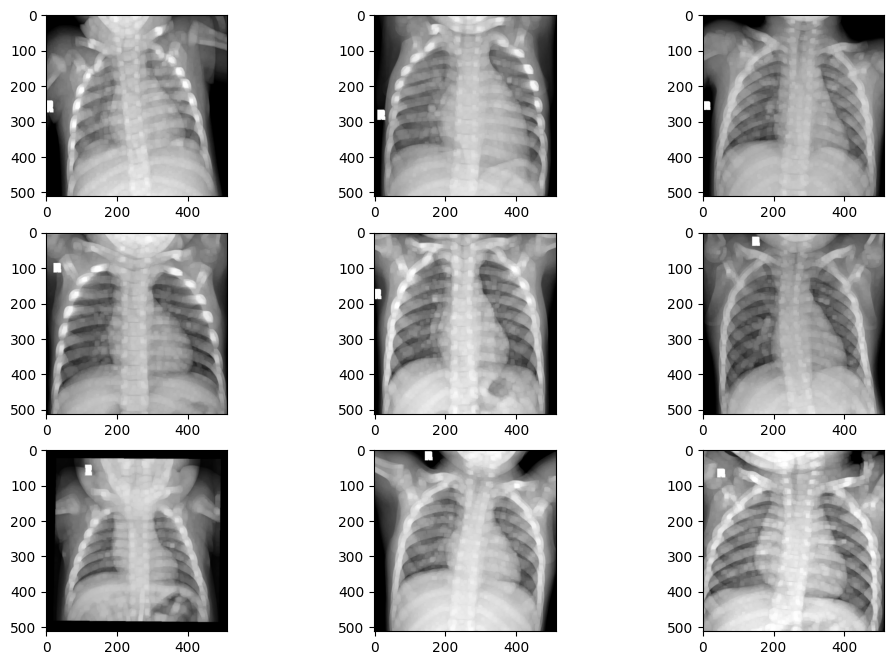

In [53]:
fig = plt.figure(figsize = (12, 8))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_dilation = cv2.dilate(img, kernel, iterations = 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_dilation)

#### Convert the images to greyscale and then apply Gaussian blur to them

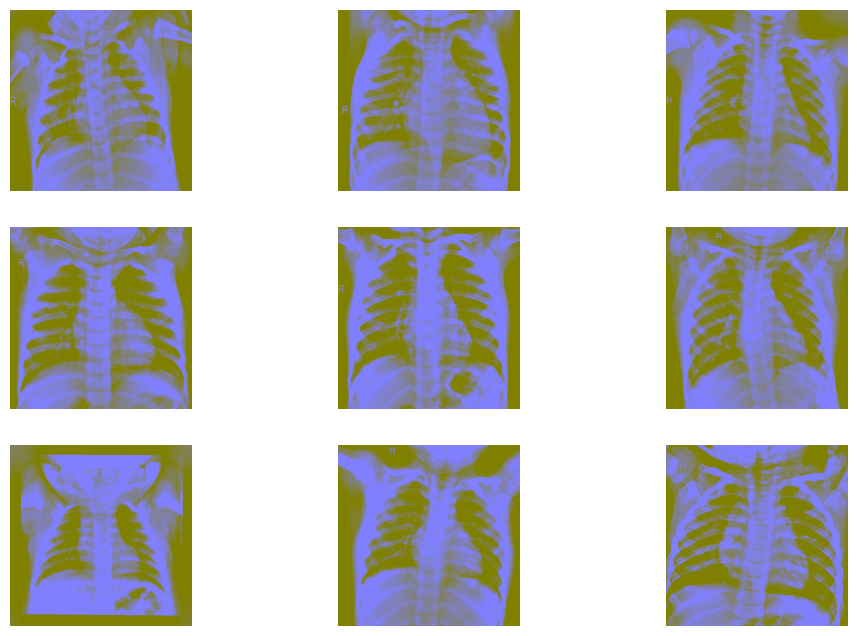

In [54]:
fig = plt.figure(figsize = (12, 8))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

#### Canny edge detection:

Canny edge detection is a technique to extract useful structural information from different vision objects and dramatically reduce the amount of data to be processed. It has been widely applied in various computer vision systems

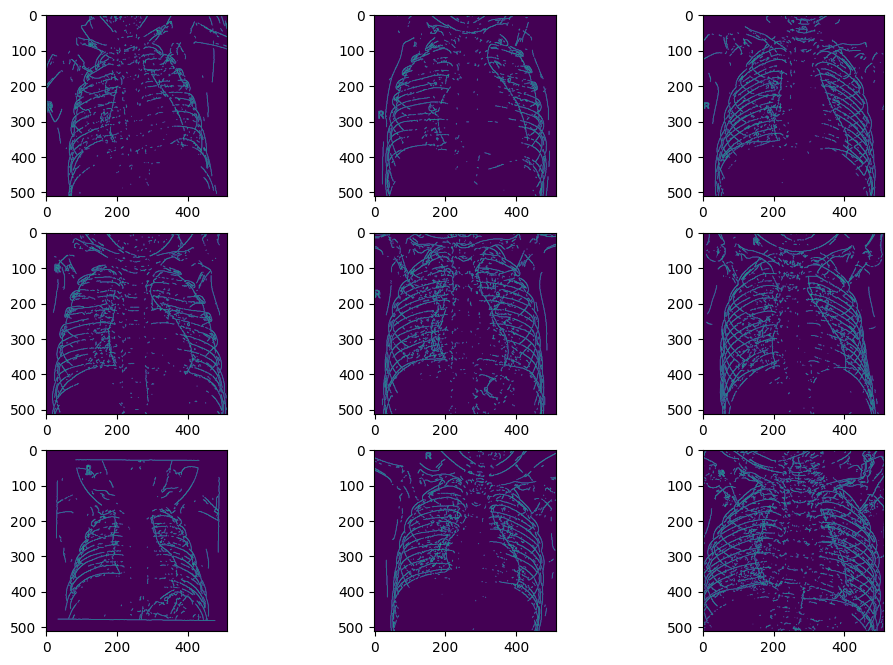

In [55]:
fig = plt.figure(figsize = (12, 8))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected_edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(detected_edges)

### Build deep learning models

In [16]:
train_dir = "/content/drive/MyDrive/chest_xray/train"
test_dir = "/content/drive/MyDrive/chest_xray/test"
validation_dir = "/content/drive/MyDrive/chest_xray/val"

In [17]:
%%time

train_datagen = ImageDataGenerator(
            rescale = 1/255.,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range = 0.3,
            zca_whitening = True,
            width_shift_range = 0.25,
            height_shift_range = 0.25,
            channel_shift_range = 0.35,
            shear_range = 0.2,
            zoom_range = 0.4)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
test_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
CPU times: user 125 ms, sys: 39.6 ms, total: 164 ms
Wall time: 201 ms


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1444: UserWarning:

This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.



#### Cache and prefetch data 


If we use flow_from_directory along with ImageDataGenerator() to set up the dataset, it will not be compatible with tensorflow.data.AUTOTUNE.Use tensorflow.keras.preprocessing.image_dataset_from_directory instead to load the dataset.

## ResNet50V2 model

In [19]:
base_model2 = tensorflow.keras.applications.ResNet50V2(weights = "imagenet",
                                                       input_shape = (224, 224, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 2)

for layer in base_model2.layers:
    layer.trainable = False

#base_model2.summary()

94668760/94668760 [==============================] - 0s 0us/step


In [20]:
model3 = Sequential()
model3.add(base_model2)
model3.add(Flatten())

model3.add(Dense(128, activation = "relu"))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(32, activation = "relu"))
model3.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model2.layers:
    layer.trainable = False

model3.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [23]:
%%time

history = model3.fit_generator(train_set, epochs = 6, validation_data = validation_set, steps_per_epoch = 100)

<timed exec>:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1885: UserWarning:

This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



Epoch 1/6
100/100 [==============================] - 402s 4s/step - loss: 0.5099 - accuracy: 0.8225 - val_loss: 0.6681 - val_accuracy: 0.7500
Epoch 2/6
100/100 [==============================] - 253s 3s/step - loss: 0.2719 - accuracy: 0.8875 - val_loss: 0.2953 - val_accuracy: 0.8125
Epoch 3/6
100/100 [==============================] - 167s 2s/step - loss: 0.2813 - accuracy: 0.8825 - val_loss: 0.3629 - val_accuracy: 0.9375
Epoch 4/6
100/100 [==============================] - 152s 2s/step - loss: 0.2126 - accuracy: 0.9119 - val_loss: 0.4827 - val_accuracy: 0.8750
Epoch 5/6
100/100 [==============================] - 105s 1s/step - loss: 0.2265 - accuracy: 0.8969 - val_loss: 0.2300 - val_accuracy: 0.9375
Epoch 6/6
100/100 [==============================] - 87s 865ms/step - loss: 0.2196 - accuracy: 0.9025 - val_loss: 0.4464 - val_accuracy: 0.8125
CPU times: user 50min, sys: 1h 2min 46s, total: 1h 52min 47s
Wall time: 19min 49s


### Visualize performance of model

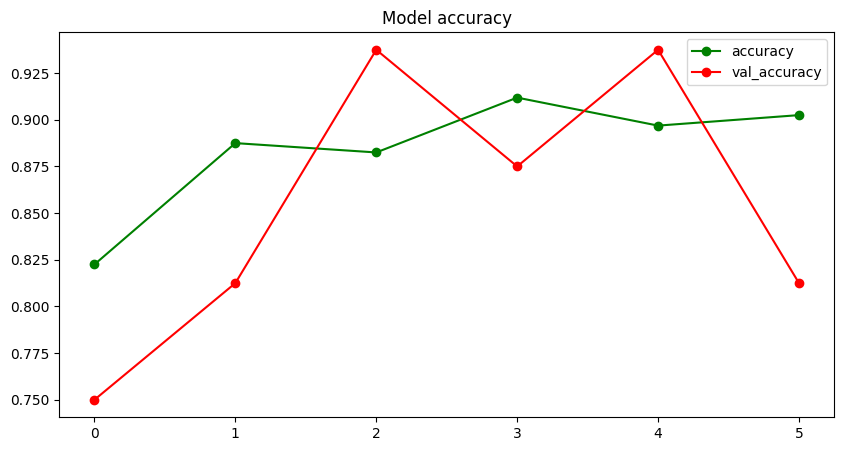

In [24]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

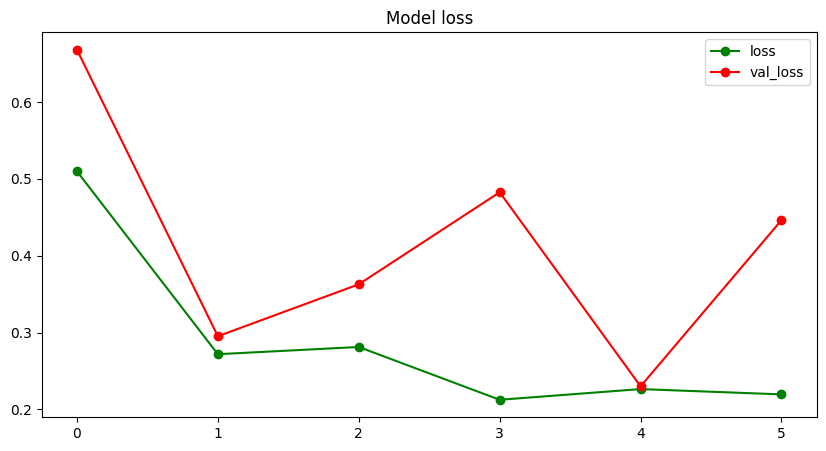

In [30]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

### Evaluate model on the test set

In [25]:
test_loss, test_accuracy = model3.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

39/50 [======================>.......] - ETA: 45s - loss: 0.3341 - accuracy: 0.8782

50/50 [==============================] - 158s 3s/step - loss: 0.3341 - accuracy: 0.8782
The testing accuracy is:  87.82051205635071 %
The testing loss is:  33.41389298439026 %


### Save the model to disk

In [26]:
model3.save("/content/drive/MyDrive/my_pneumonia_detection_model.h5")
print(colored("Model3 was succesfully saved to disk...", color = "green", attrs = ["bold", "dark"]))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



Model3 was succesfully saved to disk...


### Some time later you may need that model to use

In [28]:
model_loaded = tensorflow.keras.models.load_model("/content/drive/MyDrive/my_pneumonia_detection_model.h5")
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23837441 (90.93 MB)
Trainable params: 2726

### Use loaded model to predict new image

In [7]:
def image_prediction(new_image_path):
    test_image = image.load_img(new_image_path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    #test_image = np.reshape(test_image, (224, 224, 3))
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = test_image / 255.0
    model_loaded = tensorflow.keras.models.load_model("my_pneumonia_detection_model.h5")
    prediction = model_loaded.predict(test_image)
    test_image_for_plotting = image.load_img(new_image_path, target_size = (224, 224))
    plt.imshow(test_image_for_plotting)
    if(prediction[0] > 0.5):
        statistic = prediction[0] * 100
        print("This image is %.3f percent %s"% (statistic, "P N E U M O N I A"))
    else:
        statistic = (1.0 - prediction[0]) * 100
        print("This image is %.3f percent %s" % (statistic, "N O R M A L"))



1/1 [==============================] - 1s 1s/step
This image is 82.108 percent N O R M A L


C:\Users\mayur dabade\AppData\Local\Temp\ipykernel_9000\3901280086.py:16: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



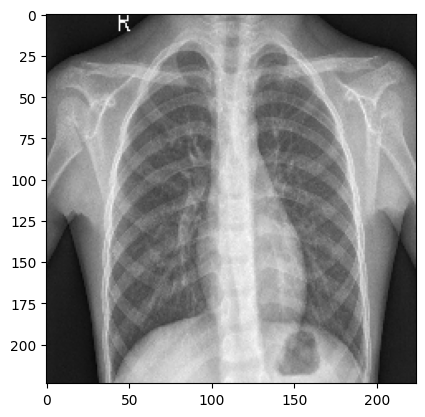

In [8]:
image_prediction("chest_xray/test/NORMAL/IM-0001-0001.jpeg")